In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')
from FRVRS import nu, fu
nu.delete_ipynb_checkpoint_folders()

Pretty printing has been turned OFF


In [4]:

# Test all the methods used in this notebook in one test suite
import unittest
if ('../tests' not in sys.path): sys.path.insert(1, '../tests')
suite = unittest.TestSuite()

# Add all test cases from each class to the suite
from test_frvrs_utils_other_functions import TestFormatTimedelta
suite.addTest(unittest.makeSuite(TestFormatTimedelta))
from test_frvrs_utils_pandas_functions import TestGetStatistics, TestGetElevensDataFrame
suite.addTest(unittest.makeSuite(TestGetStatistics))
suite.addTest(unittest.makeSuite(TestGetElevensDataFrame))
from test_frvrs_utils_patient_functions import TestGetMaxSalt, TestGetLastTag, TestIsPatientHemorrhagingFunction, TestGetTimeToHemorrhageControl
suite.addTest(unittest.makeSuite(TestGetMaxSalt))
suite.addTest(unittest.makeSuite(TestGetLastTag))
suite.addTest(unittest.makeSuite(TestIsPatientHemorrhagingFunction))
suite.addTest(unittest.makeSuite(TestGetTimeToHemorrhageControl))
from test_frvrs_utils_scene_functions import TestGetTriageTime, TestGetPercentHemorrhageControlled, TestGetTimeToLastHemorrhageControlled
suite.addTest(unittest.makeSuite(TestGetTriageTime))
suite.addTest(unittest.makeSuite(TestGetPercentHemorrhageControlled))
suite.addTest(unittest.makeSuite(TestGetTimeToLastHemorrhageControlled))

# Run the test suite
runner = unittest.TextTestRunner()
runner.run(suite)


# Create some good Mock Data

In [2]:

# Get the standard data frames
data_frames_list = nu.load_data_frames(
    verbose=False, first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df=''
)
triage_paper_df = data_frames_list['first_responder_master_registry_df']
print(triage_paper_df.shape)
file_stats_df = data_frames_list['first_responder_master_registry_file_stats_df']
print(file_stats_df.shape)
scene_stats_df = data_frames_list['first_responder_master_registry_scene_stats_df']
print(scene_stats_df.shape)
elevens_df = fu.get_elevens_data_frame(
    triage_paper_df, file_stats_df, scene_stats_df, needed_columns=['scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category']
)
print(elevens_df.shape)

(401177, 111)
(332, 19)
(486, 48)
(399048, 115)


In [12]:

from pandas import DataFrame

scene_stats_df = nu.load_object('scene_stats_df')
rows_list = []
for (session_uuid, scene_id), old_scene_df in scene_stats_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    old_percent_hemorrhage_controlled = old_scene_df.percent_hemorrhage_controlled.squeeze()
    row_dict['old_percent_hemorrhage_controlled'] = old_percent_hemorrhage_controlled

    # Get the whole scene history
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
    new_scene_df = elevens_df[mask_series]
    
    new_percent_hemorrhage_controlled = fu.get_percent_hemorrhage_controlled(new_scene_df, verbose=False)
    row_dict['new_percent_hemorrhage_controlled'] = new_percent_hemorrhage_controlled
    rows_list.append(row_dict)
df = DataFrame(rows_list)

In [20]:

mask_series = ~df.old_percent_hemorrhage_controlled.isnull() & ~df.new_percent_hemorrhage_controlled.isnull()
df.loc[mask_series, 'percent_diff'] = df[mask_series].new_percent_hemorrhage_controlled - df[mask_series].old_percent_hemorrhage_controlled
df.percent_diff.mean()

-22.498321584424286

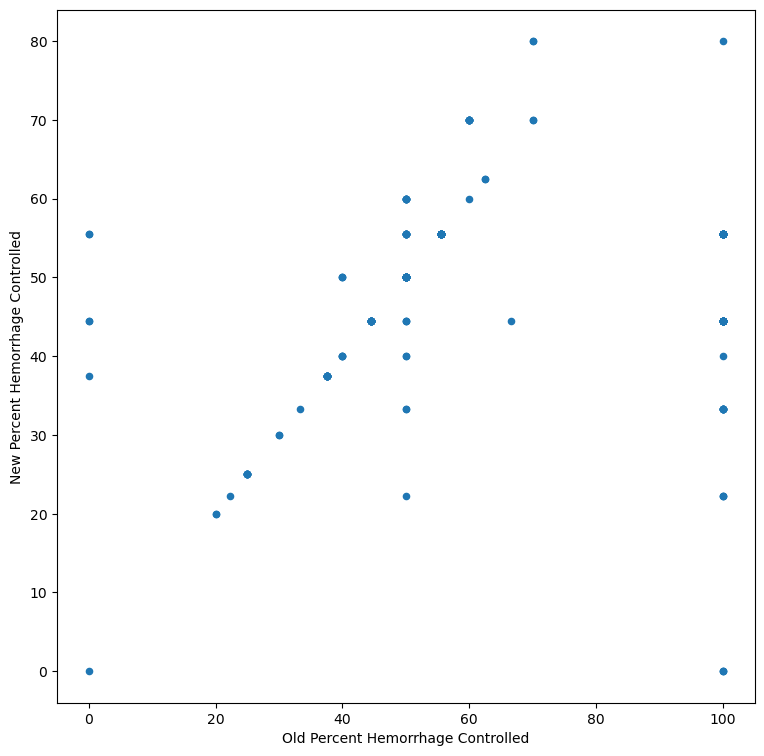

In [24]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
x_column_name = 'old_percent_hemorrhage_controlled'
y_column_name = 'new_percent_hemorrhage_controlled'
df.plot(x=x_column_name, y=y_column_name, kind='scatter', ax=ax)
x_label = ' '.join([w.title() for w in x_column_name.split('_')])
ax.set_xlabel(x_label)
y_label = ' '.join([w.title() for w in y_column_name.split('_')])
ax.set_ylabel(y_label);

In [31]:

# Find the scenes with requierd procedures in them
mask_series = ~elevens_df.injury_required_procedure.isnull() & elevens_df.injury_required_procedure.isin(fu.hemorrhage_control_procedures_list)
# display(mask_series.value_counts(dropna=False))
scene_dfs_list = []
for (session_uuid, scene_id), scene_df in elevens_df[mask_series].groupby(fu.scene_groupby_columns):
    
    # Get the entire scene history
    scene_mask_series = True
    for cn in fu.scene_groupby_columns: scene_mask_series &= (elevens_df[cn] == eval(cn))
    scene_df = elevens_df[scene_mask_series]
    
    # display(scene_df.injury_required_procedure.value_counts(dropna=False))
    mask_series =  scene_df.injury_required_procedure.isin(fu.hemorrhage_control_procedures_list)
    if (scene_df[mask_series].shape[0] >= 15): scene_dfs_list.append(scene_df)

In [32]:

from random import choices

scene_df = choices(scene_dfs_list, k=1)[0]
df = scene_df.sample(15).sort_values('action_tick')
mask_series =  df.injury_required_procedure.isin(fu.hemorrhage_control_procedures_list)
while not mask_series.sum() >= 5:
    df = scene_df.sample(15).sort_values('action_tick')
    mask_series =  df.injury_required_procedure.isin(fu.hemorrhage_control_procedures_list)
# mask_series = ~scene_df.injury_treated_injury_treated_with_wrong_treatment.isnull()
# df = scene_df[mask_series]
columns_list = [
    'action_tick', 'patient_id', 'injury_required_procedure', 'action_type', 'injury_id',
    'injury_record_required_procedure', 'injury_treated_required_procedure'
]
print(f"""
    def setUp(self):
        # Create a sample DataFrame
        self.scene_df = DataFrame({{""")
for cn in columns_list: print(f"""            '{cn}': {df[cn].tolist()},""")
print(f"""        }})""")


    def setUp(self):
        # Create a sample DataFrame
        self.scene_df = DataFrame({
            'action_tick': [223819, 223819, 223819, 241120, 256019, 256924, 285654, 289814, 317108, 319906, 321245, 367706, 368149, 568501, 571875],
            'patient_id': ['Lily_4 Root', 'Lily_2 Root', 'Bob_0 Root', 'Gloria_6 Root', nan, nan, 'Lily_2 Root', nan, nan, nan, 'Mike_7 Root', nan, nan, 'Gloria_8 Root', nan],
            'injury_required_procedure': ['woundpack', 'tourniquet', 'tourniquet', nan, nan, nan, 'tourniquet', nan, nan, nan, 'tourniquet', nan, nan, nan, nan],
            'action_type': ['INJURY_RECORD', 'INJURY_RECORD', 'INJURY_RECORD', 'S_A_L_T_WAVE_IF_CAN', 'TOOL_HOVER', 'TOOL_HOVER', 'INJURY_TREATED', 'VOICE_CAPTURE', 'TOOL_HOVER', 'TOOL_HOVER', 'INJURY_TREATED', 'TOOL_HOVER', 'TOOL_HOVER', 'S_A_L_T_WALK_IF_CAN', 'TELEPORT'],
            'injury_id': ['L Side Puncture', 'R Shin Amputation', 'L Thigh Laceration', nan, nan, nan, 'R Shin Amputation', nan, nan, nan, 'L Th

In [33]:

# Get all the non-hemorrhaging procedures
import pandas as pd
from pandas import DataFrame
from numpy import nan

scene_df = DataFrame({
    'action_tick': [223819, 223819, 223819, 241120, 256019, 256924, 285654, 289814, 317108, 319906, 321245, 367706, 368149, 568501, 571875],
    'patient_id': [
        'Lily_4 Root', 'Lily_2 Root', 'Bob_0 Root', 'Gloria_6 Root', nan, nan, 'Lily_2 Root', nan,
        nan, nan, 'Mike_7 Root', nan, nan, 'Gloria_8 Root', nan
    ],
    'injury_required_procedure': ['woundpack', 'tourniquet', 'tourniquet', nan, nan, nan, 'tourniquet', nan, nan, nan, 'tourniquet', nan, nan, nan, nan],
    'action_type': [
        'INJURY_RECORD', 'INJURY_RECORD', 'INJURY_RECORD', 'S_A_L_T_WAVE_IF_CAN', 'TOOL_HOVER', 'TOOL_HOVER', 'INJURY_TREATED', 'VOICE_CAPTURE',
        'TOOL_HOVER', 'TOOL_HOVER', 'INJURY_TREATED', 'TOOL_HOVER', 'TOOL_HOVER', 'S_A_L_T_WALK_IF_CAN', 'TELEPORT'
    ],
    'injury_id': [
        'L Side Puncture', 'R Shin Amputation', 'L Thigh Laceration', nan, nan, nan, 'R Shin Amputation', nan,
        nan, nan, 'L Thigh Puncture', nan, nan, nan, nan
    ],
    'injury_record_required_procedure': ['woundpack', 'tourniquet', 'tourniquet', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
    'injury_treated_required_procedure': [nan, nan, nan, nan, nan, nan, 'tourniquet', nan, nan, nan, 'tourniquet', nan, nan, nan, nan]
})
fu.get_time_to_last_hemorrhage_controlled(scene_df)

61835

In [34]:

scene_start = fu.get_scene_start(scene_df)
last_controlled_time = 0
for patient_id, patient_df in scene_df.groupby('patient_id'):
    if (fu.get_is_patient_hemorrhaging(patient_df)):
        # print(fu.get_time_to_hemorrhage_control(patient_df, scene_start=scene_start))
        controlled_time = 0
        on_columns_list = ['injury_id']
        merge_columns_list = ['action_tick'] + on_columns_list
        for control_procedure in fu.hemorrhage_control_procedures_list:
            mask_series = patient_df.injury_record_required_procedure.isin([control_procedure])
            if mask_series.any():
                print(control_procedure)
                hemorrhage_df = patient_df[mask_series][merge_columns_list]
                display(hemorrhage_df)
        display(patient_df)

tourniquet


,action_tick,injury_id
2,223819,L Thigh Laceration


,action_tick,patient_id,injury_required_procedure,action_type,injury_id,injury_record_required_procedure,injury_treated_required_procedure
2,223819,Bob_0 Root,tourniquet,INJURY_RECORD,L Thigh Laceration,tourniquet,NaN


tourniquet


,action_tick,injury_id
1,223819,R Shin Amputation


,action_tick,patient_id,injury_required_procedure,action_type,injury_id,injury_record_required_procedure,injury_treated_required_procedure
1,223819,Lily_2 Root,tourniquet,INJURY_RECORD,R Shin Amputation,tourniquet,NaN
6,285654,Lily_2 Root,tourniquet,INJURY_TREATED,R Shin Amputation,NaN,tourniquet


woundpack


,action_tick,injury_id
0,223819,L Side Puncture


,action_tick,patient_id,injury_required_procedure,action_type,injury_id,injury_record_required_procedure,injury_treated_required_procedure
0,223819,Lily_4 Root,woundpack,INJURY_RECORD,L Side Puncture,woundpack,NaN


,action_tick,patient_id,injury_required_procedure,action_type,injury_id,injury_record_required_procedure,injury_treated_required_procedure
10,321245,Mike_7 Root,tourniquet,INJURY_TREATED,L Thigh Puncture,NaN,tourniquet


In [ ]:

# Find an injury where the required procedures don't match
columns_list = ['injury_record_required_procedure', 'injury_treated_required_procedure']
rows_list = []
for (session_uuid, scene_id, patient_id, injury_id), injury_df in elevens_df.groupby(fu.injury_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.injury_groupby_columns}
    df = injury_df[columns_list].drop_duplicates()
    row_dict['row_count'] = df.shape[0]
    rows_list.append(row_dict)
df = DataFrame(rows_list)
df.sort_values('row_count', ascending=False)

In [ ]:

# Find an injury where the required procedures don't match
columns_list = ['injury_record_required_procedure', 'injury_treated_required_procedure']
rows_list = []
for (session_uuid, scene_id, patient_id, injury_id), injury_df in elevens_df.groupby(fu.injury_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.injury_groupby_columns}
    df = injury_df[columns_list].drop_duplicates()
    if df.shape[0] == 1: display(df); break

In [ ]:

# Get the scenes with the highest hemorrhage control percentage
max_percent = scene_stats_df.percent_hemorrhage_controlled.max()
mask_series = (scene_stats_df.percent_hemorrhage_controlled == max_percent)
df = scene_stats_df[mask_series]
on_columns = sorted(set(elevens_df.columns).intersection(set(df.columns)))
merge_df = elevens_df.merge(df, on=on_columns, how='inner')

In [ ]:

mask_series = ~scene_df.injury_required_procedure.isnull()
print(scene_df[mask_series].shape)
scene_df[mask_series].injury_required_procedure.unique()

In [ ]:

mask_series = ~scene_df.injury_treated_injury_treated_with_wrong_treatment.isnull()
print(scene_df[mask_series].shape)
scene_df[mask_series].injury_treated_injury_treated_with_wrong_treatment.unique()

In [4]:

# Create a sample DataFrame
import pandas as pd
from pandas import DataFrame
from numpy import nan

procedures_list = [
    'tourniquet', 'tourniquet', 'tourniquet', 'tourniquet', 'woundpack',
    'tourniquet', 'decompress', 'woundpack', 'tourniquet', 'gauzePressure'
]
all_trues = [True] * len(procedures_list)
some_trues = [
    False, False, False, False, False,
    True, False, False, False, False
]
all_falses = [False] * len(procedures_list)
scene_df = DataFrame({
    'action_tick': [
        53712, 111438, 173005, 201999, 235440,
        249305, 296810, 329527, 363492, 442375
    ],
    'patient_id': [
        'Gloria_2 Root', 'Lily_1 Root', 'Lily_1 Root', 'Mike_3 Root', 'Helga_0 Root',
        'Helga_0 Root', 'Mike_6 Root', 'Mike_9 Root', 'Mike_9 Root', 'Mike_4 Root'
    ],
    'injury_id': [
        'L Shin Amputation', 'R Thigh Laceration', 'R Bicep Puncture', 'R Wrist Amputation', 'L Stomach Puncture',
        'L Thigh Puncture', 'R Chest Collapse', 'L Side Puncture', 'L Thigh Puncture', 'R Palm Laceration'
    ],
    'injury_required_procedure': procedures_list,
    'injury_record_required_procedure': procedures_list,
    'injury_treated_required_procedure': procedures_list,
    'injury_treated_injury_treated_with_wrong_treatment': some_trues,
    'injury_treated_injury_treated': some_trues
})
fu.get_percent_hemorrhage_controlled(scene_df, verbose=True)

AttributeError: 'DataFrame' object has no attribute 'tool_applied_type'

In [18]:

# Test the function with duplicate treatment entries for the same injury
duplicate_df = scene_df.append(scene_df.iloc[3])
fu.get_percent_hemorrhage_controlled(duplicate_df)

87.5

In [8]:

# Loop through each injury, examining its required procedures and wrong treatments
columns_list = [
    'patient_id', 'injury_id', 'injury_required_procedure', 'injury_record_required_procedure', 'injury_treated_required_procedure',
    'injury_treated_injury_treated_with_wrong_treatment'
]
for (patient_id, injury_id), injury_df in scene_df.groupby(['patient_id', 'injury_id']):
    print()
    for cn in columns_list: print(f'{cn}: {injury_df[cn].tolist()}')


patient_id: ['Gloria_2 Root']
injury_id: ['L Shin Amputation']
injury_required_procedure: ['tourniquet']
injury_record_required_procedure: ['tourniquet']
injury_treated_required_procedure: ['tourniquet']
injury_treated_injury_treated_with_wrong_treatment: [False]

patient_id: ['Helga_0 Root']
injury_id: ['L Stomach Puncture']
injury_required_procedure: ['woundpack']
injury_record_required_procedure: ['woundpack']
injury_treated_required_procedure: ['woundpack']
injury_treated_injury_treated_with_wrong_treatment: [False]

patient_id: ['Helga_0 Root']
injury_id: ['L Thigh Puncture']
injury_required_procedure: ['tourniquet']
injury_record_required_procedure: ['tourniquet']
injury_treated_required_procedure: ['tourniquet']
injury_treated_injury_treated_with_wrong_treatment: [True]

patient_id: ['Lily_1 Root']
injury_id: ['R Bicep Puncture']
injury_required_procedure: ['tourniquet']
injury_record_required_procedure: ['tourniquet']
injury_treated_required_procedure: ['tourniquet']
injury_tr

In [66]:

for (session_uuid, scene_id, patient_id), patient_df in merge_df[mask_series].groupby(fu.patient_groupby_columns):
    
    # Get the entire patient history
    patient_mask_series = True
    for cn in fu.patient_groupby_columns: patient_mask_series &= (merge_df[cn] == eval(cn))
    patient_df = merge_df[patient_mask_series]
    
    if (patient_df.shape[0] >= 5): break

In [29]:

from pandas import Series, concat

for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    if (responder_category != 'Nurse or Other HP'):
        describable_df = concat([
            Series(
                [fu.get_triage_time(scene_df) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
            ).to_frame().rename(columns={0: 'triage_time'}),
            Series(
                [fu.get_time_to_last_hemorrhage_controlled(scene_df) for _, scene_df in responder_categories_df.groupby(fu.scene_groupby_columns)]
            ).to_frame().rename(columns={0: 'last_controlled_time'})
        ], axis='columns')
        break

In [34]:

df = describable_df.sample(5)
print(f"""
        # Create a sample DataFrame
        self.describable_df = DataFrame({{
            'triage_time': {df.triage_time.tolist()},
            'last_controlled_time': {df.last_controlled_time.tolist()}
        }})""")


        # Create a sample DataFrame
        self.describable_df = DataFrame({
            'triage_time': [461207, 615663, 649185, 19615, 488626],
            'last_controlled_time': [377263, 574558, 462280, 0, 321956]
        })


In [37]:

# Create a sample DataFrame
describable_df = DataFrame({
    'triage_time': [461207, 615663, 649185, 19615, 488626],
    'last_controlled_time': [377263, 574558, 462280, 0, 321956]
})
expected_df = DataFrame(
    {
        'triage_time': [446859.2, 19615.0, 488626.0, 251951.57452415334, 19615.0, 461207.0, 488626.0, 615663.0, 649185.0],
        'last_controlled_time': [347211.4, 0.0, 377263.0, 216231.3283379631, 0.0, 321956.0, 377263.0, 462280.0, 574558.0]
    },
    index=['mean', 'mode', 'median', 'SD', 'min', '25%', '50%', '75%', 'max']
)

# Test with all columns
columns_list = describable_df.columns.tolist()
actual_df = fu.get_statistics(describable_df, columns_list)
actual_df.to_dict(orient='list')

{'triage_time': [446859.2, 19615.0, 488626.0, 251951.57452415334, 19615.0, 461207.0, 488626.0, 615663.0, 649185.0], 'last_controlled_time': [347211.4, 0.0, 377263.0, 216231.3283379631, 0.0, 321956.0, 377263.0, 462280.0, 574558.0]}

In [6]:

for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    if scene_df.shape[0] >= 2: break
df = scene_df.sample(3)
print(f"""
        # Create a mock DataFrame with scene start and end time columns
        self.scene_df = DataFrame({{
            "action_tick": {df.action_tick.tolist()}
        }})""")


        # Create a mock DataFrame with scene start and end time columns
        self.scene_df = pd.DataFrame({
            "action_tick": [575896, 693191, 699598]
        })


In [9]:

# Create a mock DataFrame with scene start and end time columns
from pandas import DataFrame
scene_df = DataFrame({
    "action_tick": [575896, 693191, 699598]
})
fu.get_triage_time(scene_df)

123702

In [3]:

# Example usage
zero_seconds_s = fu.format_timedelta(timedelta(seconds=0), minimum_unit='seconds')
zero_seconds_m = fu.format_timedelta(timedelta(seconds=0), minimum_unit='minutes')
thirty_seconds_s = fu.format_timedelta(timedelta(seconds=30), minimum_unit='seconds')
thirty_seconds_m = fu.format_timedelta(timedelta(seconds=30), minimum_unit='minutes')
one_minute_s = fu.format_timedelta(timedelta(minutes=1, seconds=0), minimum_unit='seconds')
one_minute_m = fu.format_timedelta(timedelta(minutes=1, seconds=0), minimum_unit='minutes')
a_minute_and_a_half_s = fu.format_timedelta(timedelta(minutes=1, seconds=30), minimum_unit='seconds')
a_minute_and_a_half_m = fu.format_timedelta(timedelta(minutes=1, seconds=30), minimum_unit='minutes')
two_minute_s = fu.format_timedelta(timedelta(minutes=2, seconds=0), minimum_unit='seconds')
two_minute_m = fu.format_timedelta(timedelta(minutes=2, seconds=0), minimum_unit='minutes')

print(
    f"zero seconds: '{zero_seconds_s}' or '{zero_seconds_m}'\n"
    f"thirty seconds: '{thirty_seconds_s}' or '{thirty_seconds_m}'\n"
    f"one minute: '{one_minute_s}' or '{one_minute_m}'\n"
    f"a minute and a half: '{a_minute_and_a_half_s}' or '{a_minute_and_a_half_m}'\n"
    f"two minutes: '{two_minute_s}' or '{two_minute_m}'"
)

zero seconds: '0 sec' or '00:00'
thirty seconds: '30 sec' or '00:30'
one minute: '1 min' or '01:00'
a minute and a half: '1:30' or '01:30'
two minutes: '2 min' or '02:00'


In [48]:

mask_series = ~elevens_df.injury_required_procedure.isnull()
for (session_uuid, scene_id, patient_id), patient_df in elevens_df[mask_series].groupby(fu.patient_groupby_columns):
    if patient_df.shape[0] >= 3:
        
        # Get the entire history of this patient
        mask_series = True
        for cn in fu.patient_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
        patient_df = elevens_df[mask_series]
        
        mask_series = ~patient_df.injury_record_required_procedure.isnull()
        record_count = patient_df[mask_series].shape[0]
        mask_series = ~patient_df.injury_treated_required_procedure.isnull()
        treated_count = patient_df[mask_series].shape[0]
        if (record_count > 1) and (treated_count > 1): break

In [52]:

mask_series = ~patient_df.injury_required_procedure.isnull()
df = patient_df[mask_series].sample(3)
print(f"""
        # Create mock data for the patient DataFrame
        self.patient_df = DataFrame({{
            'action_type': {df.action_type.tolist()},
            'action_tick': {df.action_tick.tolist()},
            'injury_id': {df.injury_id.tolist()},
            'injury_record_required_procedure': {df.injury_record_required_procedure.tolist()},
            'injury_treated_required_procedure': {df.injury_treated_required_procedure.tolist()}
        }})""")


        # Create mock data for the patient DataFrame
        self.patient_df = DataFrame({
            'action_type': ['INJURY_TREATED', 'INJURY_TREATED', 'INJURY_RECORD'],
            'action_tick': [455202, 448909, 305828],
            'injury_id': ['R Side Puncture', 'R Thigh Laceration', 'R Side Puncture'],
            'injury_record_required_procedure': [nan, nan, 'woundpack'],
            'injury_treated_required_procedure': ['woundpack', 'gauzePressure', nan]
        })


In [53]:

fu.responder_negotiations_list

['PULSE_TAKEN', 'PATIENT_ENGAGED', 'INJURY_TREATED', 'TAG_APPLIED', 'TOOL_APPLIED']

In [55]:

# Create mock data for the patient DataFrame
from numpy import nan

# Create mock data for the patient DataFrame
patient_df = DataFrame({
    'action_type': ['INJURY_TREATED', 'INJURY_TREATED', 'INJURY_RECORD'],
    'action_tick': [455202, 448909, 305828],
    'injury_id': ['R Side Puncture', 'R Thigh Laceration', 'R Side Puncture'],
    'injury_record_required_procedure': [nan, nan, 'woundpack'],
    'injury_treated_required_procedure': ['woundpack', 'gauzePressure', nan]
})
fu.get_time_to_hemorrhage_control(patient_df, verbose=False)

6293

In [56]:

scene_start = 300_000
fu.get_time_to_hemorrhage_control(patient_df, scene_start=scene_start, verbose=False)

155202

In [ ]:

functions_list = [
    'colors_category_order', 'error_table_df', 'errors_category_order', 'format_timedelta', 'get_elevens_data_frame', 'get_last_tag',
    'get_max_salt', 'get_percent_hemorrhage_controlled', 'get_statistics', 'get_time_to_hemorrhage_control',
    'get_time_to_last_hemorrhage_controlled', 'get_triage_time', 'hemorrhage_control_procedures_list', 'is_patient_hemorrhaging',
    'patient_groupby_columns', 'salt_category_order', 'salt_to_tag_dict', 'scene_groupby_columns', 'tag_colors'
]
function_regex = re.compile(r'\b(' + '|'.join(functions_list) + r')\b')

In [4]:

# Create another test suite
suite = unittest.TestSuite()

# Add all test cases from the class to the suite
from test_color_functions import TestColorDistanceFrom, TestGetTextColor
suite.addTest(unittest.makeSuite(TestColorDistanceFrom))
suite.addTest(unittest.makeSuite(TestGetTextColor))

# Run the test suite
runner = unittest.TextTestRunner()
runner.run(suite)

......
----------------------------------------------------------------------
Ran 6 tests in 0.008s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>